In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm #Shows a progress bar for loops
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/"

'10 self.jpg'   1655396564339.pdf	   certificate.pdf    LoR.pdf
'12 (1).jpg'   'Abhinav resume.pdf'	  'Colab Notebooks'  'Plant Dataset'
 12.jpg        'Approaching data.gsheet'   Deep_Fake.ipynb   'Untitled spreadsheet.gsheet'


In [ ]:
!ls "/content/drive/MyDrive/Plant Dataset"

'archive (1).zip'


[INFO] Loading images...
[INFO] Image loading completed
Total images: 20638
Training samples: 14446
Validation samples: 3096
Test samples: 3096


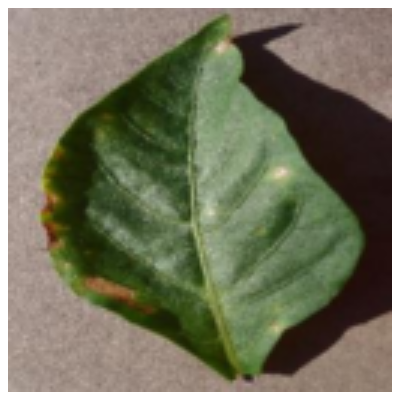

In [ ]:
import os
import zipfile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image

# Step 1: Extract ZIP File from Google Drive
zip_path = "/content/drive/MyDrive/Plant Dataset/archive (1).zip"  # Update if needed
extract_path = "/content/plant_dataset"

if not os.path.exists(extract_path):  # Extract only if not already extracted
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")

# Step 2: Define Dataset Class
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image and apply transformations
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

# Step 3: Load Images and Labels
def load_images(directory_root):
    image_list, label_list = [], []
    print("[INFO] Loading images...")

    for disease_folder in os.listdir(directory_root):
        disease_folder_path = os.path.join(directory_root, disease_folder)
        if not os.path.isdir(disease_folder_path):
            continue

        for img_name in os.listdir(disease_folder_path):
            if img_name.startswith("."):
                continue
            img_path = os.path.join(disease_folder_path, img_name)
            if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_list.append(img_path)
                label_list.append(disease_folder)

    print("[INFO] Image loading completed")
    print(f"Total images: {len(image_list)}")
    return image_list, label_list

# Set dataset path
dataset_root = "/content/plant_dataset/PlantVillage"  # Update if needed

# Load images
image_paths, labels = load_images(dataset_root)

# Encode labels as integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Train, validation, and test splits
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded
)
valid_paths, test_paths, valid_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(valid_paths)}")
print(f"Test samples: {len(test_paths)}")

# Step 4: Define Data Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Step 5: Create DataLoaders
train_dataset = PlantDiseaseDataset(train_paths, train_labels, transform=transform)
valid_dataset = PlantDiseaseDataset(valid_paths, valid_labels, transform=transform)
test_dataset = PlantDiseaseDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 6: Display a Sample Image
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()


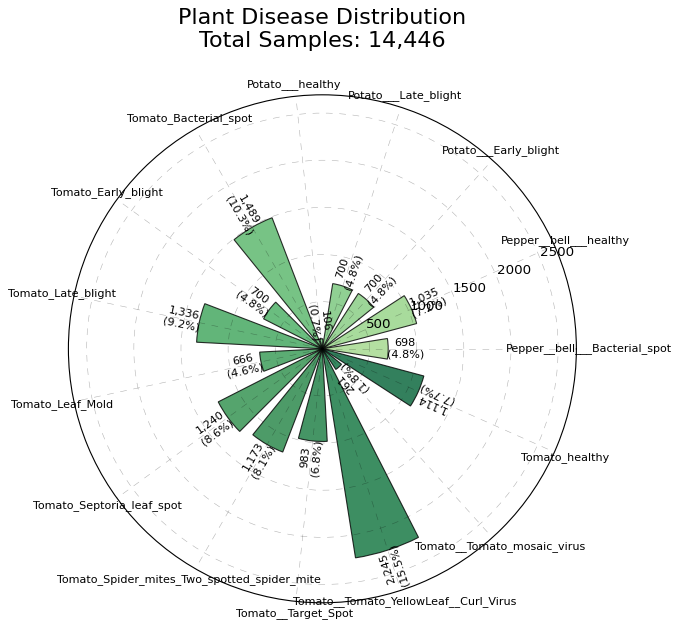

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def visualize_class_distribution(labels, class_names):
    class_counts = Counter(labels)
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[0])
    counts = [count for _, count in sorted_counts]
    class_labels = [class_names[idx] for idx, _ in sorted_counts]
    percentages = [count/len(labels)*100 for count in counts]

    plt.figure(figsize=(10,8))
    ax = plt.subplot(111, projection='polar')
    angles = np.linspace(0, 2*np.pi, len(counts), endpoint=False)
    colors = plt.cm.YlGn(np.linspace(0.4, 0.9, len(counts)))
    bars = ax.bar(angles, counts, width=2*np.pi/len(counts)*0.75, alpha=0.8, color=colors)

    for angle, count, percentage in zip(angles, counts, percentages):
        label_radius = count + (max(counts) * 0.08)
        label = f'{count:,}\n({percentage:.1f}%)'
        ax.text(angle, label_radius, label, ha='center', va='center', fontsize=10,
                rotation=np.degrees(angle) if -90 <= np.degrees(angle) <= 90 else np.degrees(angle) + 180)

    ax.set_title('Plant Disease Distribution\nTotal Samples: {:,}'.format(sum(counts)), y=1.05, fontsize=20, pad=20)
    ax.set_xticks(angles)
    ax.set_xticklabels(class_labels, fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim(0, max(counts) * 1.2)
    plt.tight_layout()
    plt.show()

plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
visualize_class_distribution(train_labels, label_encoder.classes_)

In [ ]:
# Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),           # Data augmentation for training
    transforms.RandomRotation(30),              # Random rotation for variability
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

valid_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),              # Consistent resizing for validation/test
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Same normalization as training
])

# Create datasets with appropriate transformations
train_dataset = PlantDiseaseDataset(train_paths, train_labels, transform=train_transform)
valid_dataset = PlantDiseaseDataset(valid_paths, valid_labels, transform=valid_test_transform)
test_dataset = PlantDiseaseDataset(test_paths, test_labels, transform=valid_test_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle for training
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) # No shuffle for validation/test
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # No shuffle for test


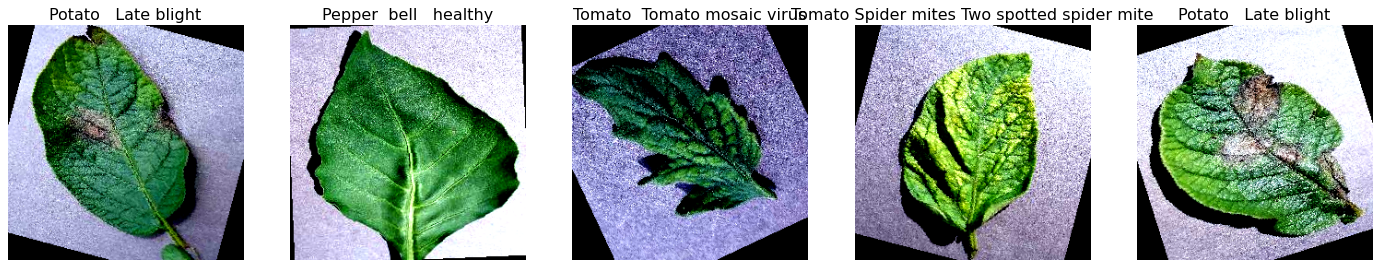

In [ ]:
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(22, 5))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # De-normalize
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(label_encoder.inverse_transform([label])[0].replace('_',' '))  # Convert label back to class name
        plt.axis('off')
    plt.show()

visualize_samples(train_dataset)

In [ ]:
for inputs, labels in test_loader:
    print(f"Batch inputs shape: {inputs.shape}")  # Should be [batch_size, 3, 128, 128]
    print(f"Batch labels shape: {labels.shape}")  # Should be [batch_size]
    print(f"First 5 samples labels: {labels[:5]}")   # Print first 5 labels
    break

Batch inputs shape: torch.Size([32, 3, 256, 256])
Batch labels shape: torch.Size([32])
First 5 samples labels: tensor([11,  2, 14, 12, 11])


In [ ]:
class PlantDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseModel, self).__init__()
        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Output: 32x128x128 (assuming input is 3x256x256)
        )
        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Output: 64x64x64
        )
        # Convolutional Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Output: 128x32x32
        )
        # Convolutional Block 4
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Output: 256x16x16
        )
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output: 256x1x1
        # Fully Connected Layers
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),  # Adjusted input size after GAP
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.global_avg_pool(x)
        x = self.fc_block(x)
        return x


In [ ]:
# Initialize model, loss, optimizer
num_classes = len(label_encoder.classes_)
print(f"Number of Classes: {num_classes}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

model = PlantDiseaseModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

Number of Classes: 15
Device Used: cuda


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, save_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)  # Save the best model
            print(f"[INFO] Model checkpoint saved to {self.save_path}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("[INFO] Early stopping triggered.")
                return True
        return False

def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(data_loader)
    accuracy = correct / total * 100
    return val_loss, accuracy


def train_model(
    model, train_loader, valid_loader, criterion, optimizer, epochs, early_stopping=None):
    train_losses, valid_losses, valid_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch+1}/{epochs}", total=len(train_loader))

        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"Train Loss": loss.item()})

        # Record training loss
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        val_loss, val_accuracy = evaluate_model(model, valid_loader, criterion)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

        # Print epoch summary
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

        # Early stopping
        if early_stopping and early_stopping(val_loss, model):
            print("[INFO] Early stopping triggered.")
            break

    return train_losses, valid_losses, valid_accuracies


In [ ]:
n_epochs = 100

early_stopping = EarlyStopping(patience=4, min_delta=0.01, save_path="best_model.pth")
train_losses, valid_losses, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, epochs=n_epochs, early_stopping=early_stopping
)

Epoch 1/100: 100%|██████████| 452/452 [01:19<00:00,  5.67it/s, Train Loss=2.31]


Epoch 1: Train Loss = 2.4370, Val Loss = 2.1866, Val Accuracy = 32.85%
[INFO] Model checkpoint saved to best_model.pth


Epoch 2/100: 100%|██████████| 452/452 [01:17<00:00,  5.86it/s, Train Loss=1.72]


Epoch 2: Train Loss = 2.0971, Val Loss = 1.8862, Val Accuracy = 41.25%
[INFO] Model checkpoint saved to best_model.pth


Epoch 3/100: 100%|██████████| 452/452 [01:15<00:00,  5.98it/s, Train Loss=1.82]


Epoch 3: Train Loss = 1.8763, Val Loss = 1.6649, Val Accuracy = 47.67%
[INFO] Model checkpoint saved to best_model.pth


Epoch 4/100: 100%|██████████| 452/452 [01:14<00:00,  6.07it/s, Train Loss=1.66]


Epoch 4: Train Loss = 1.7116, Val Loss = 1.5061, Val Accuracy = 54.97%
[INFO] Model checkpoint saved to best_model.pth


Epoch 5/100: 100%|██████████| 452/452 [01:15<00:00,  5.99it/s, Train Loss=1.25]


Epoch 5: Train Loss = 1.5713, Val Loss = 1.3608, Val Accuracy = 59.53%
[INFO] Model checkpoint saved to best_model.pth


Epoch 6/100: 100%|██████████| 452/452 [01:14<00:00,  6.10it/s, Train Loss=1.45]


Epoch 6: Train Loss = 1.4490, Val Loss = 1.2694, Val Accuracy = 61.95%
[INFO] Model checkpoint saved to best_model.pth


Epoch 7/100: 100%|██████████| 452/452 [01:15<00:00,  6.00it/s, Train Loss=1.43]


Epoch 7: Train Loss = 1.3553, Val Loss = 1.1712, Val Accuracy = 65.70%
[INFO] Model checkpoint saved to best_model.pth


Epoch 8/100: 100%|██████████| 452/452 [01:13<00:00,  6.11it/s, Train Loss=1.48]


Epoch 8: Train Loss = 1.2664, Val Loss = 1.0781, Val Accuracy = 68.28%
[INFO] Model checkpoint saved to best_model.pth


Epoch 9/100: 100%|██████████| 452/452 [01:13<00:00,  6.12it/s, Train Loss=1.31]


Epoch 9: Train Loss = 1.2017, Val Loss = 1.1062, Val Accuracy = 64.31%


Epoch 10/100: 100%|██████████| 452/452 [01:13<00:00,  6.11it/s, Train Loss=1.27]


Epoch 10: Train Loss = 1.1402, Val Loss = 0.9691, Val Accuracy = 70.96%
[INFO] Model checkpoint saved to best_model.pth


Epoch 11/100: 100%|██████████| 452/452 [01:16<00:00,  5.94it/s, Train Loss=0.693]


Epoch 11: Train Loss = 1.0887, Val Loss = 0.9145, Val Accuracy = 71.61%
[INFO] Model checkpoint saved to best_model.pth


Epoch 12/100: 100%|██████████| 452/452 [01:15<00:00,  6.00it/s, Train Loss=1.34]


Epoch 12: Train Loss = 1.0296, Val Loss = 0.8689, Val Accuracy = 74.06%
[INFO] Model checkpoint saved to best_model.pth


Epoch 13/100: 100%|██████████| 452/452 [01:15<00:00,  5.98it/s, Train Loss=1.17]


Epoch 13: Train Loss = 0.9862, Val Loss = 0.8101, Val Accuracy = 76.07%
[INFO] Model checkpoint saved to best_model.pth


Epoch 14/100: 100%|██████████| 452/452 [01:15<00:00,  5.98it/s, Train Loss=1.51]


Epoch 14: Train Loss = 0.9506, Val Loss = 0.8487, Val Accuracy = 73.29%


Epoch 15/100: 100%|██████████| 452/452 [01:15<00:00,  5.99it/s, Train Loss=0.998]


Epoch 15: Train Loss = 0.9019, Val Loss = 0.8185, Val Accuracy = 73.77%


Epoch 16/100: 100%|██████████| 452/452 [01:15<00:00,  5.98it/s, Train Loss=0.965]


Epoch 16: Train Loss = 0.8763, Val Loss = 0.8253, Val Accuracy = 73.29%


Epoch 17/100: 100%|██████████| 452/452 [01:14<00:00,  6.03it/s, Train Loss=0.851]


Epoch 17: Train Loss = 0.8218, Val Loss = 0.7496, Val Accuracy = 75.45%
[INFO] Model checkpoint saved to best_model.pth


Epoch 18/100: 100%|██████████| 452/452 [01:15<00:00,  5.99it/s, Train Loss=0.923]


Epoch 18: Train Loss = 0.7961, Val Loss = 0.6469, Val Accuracy = 80.43%
[INFO] Model checkpoint saved to best_model.pth


Epoch 19/100: 100%|██████████| 452/452 [01:16<00:00,  5.89it/s, Train Loss=0.613]


Epoch 19: Train Loss = 0.7596, Val Loss = 0.5644, Val Accuracy = 83.33%
[INFO] Model checkpoint saved to best_model.pth


Epoch 20/100: 100%|██████████| 452/452 [01:15<00:00,  5.95it/s, Train Loss=1.28]


Epoch 20: Train Loss = 0.7401, Val Loss = 0.6399, Val Accuracy = 78.88%


Epoch 21/100: 100%|██████████| 452/452 [01:17<00:00,  5.87it/s, Train Loss=0.568]


Epoch 21: Train Loss = 0.7049, Val Loss = 0.5638, Val Accuracy = 82.53%


Epoch 22/100: 100%|██████████| 452/452 [01:14<00:00,  6.03it/s, Train Loss=0.695]


Epoch 22: Train Loss = 0.6722, Val Loss = 0.7112, Val Accuracy = 77.23%


Epoch 23/100: 100%|██████████| 452/452 [01:16<00:00,  5.94it/s, Train Loss=0.834]


Epoch 23: Train Loss = 0.6532, Val Loss = 0.5208, Val Accuracy = 83.66%
[INFO] Model checkpoint saved to best_model.pth


Epoch 24/100: 100%|██████████| 452/452 [01:16<00:00,  5.94it/s, Train Loss=1.08]


Epoch 24: Train Loss = 0.6351, Val Loss = 0.5007, Val Accuracy = 84.79%
[INFO] Model checkpoint saved to best_model.pth


Epoch 25/100: 100%|██████████| 452/452 [01:16<00:00,  5.91it/s, Train Loss=0.895]


Epoch 25: Train Loss = 0.6044, Val Loss = 0.4486, Val Accuracy = 87.53%
[INFO] Model checkpoint saved to best_model.pth


Epoch 26/100: 100%|██████████| 452/452 [01:14<00:00,  6.06it/s, Train Loss=0.682]


Epoch 26: Train Loss = 0.5965, Val Loss = 0.4174, Val Accuracy = 88.31%
[INFO] Model checkpoint saved to best_model.pth


Epoch 27/100: 100%|██████████| 452/452 [01:13<00:00,  6.12it/s, Train Loss=0.318]


Epoch 27: Train Loss = 0.5637, Val Loss = 0.4099, Val Accuracy = 88.24%


Epoch 28/100: 100%|██████████| 452/452 [01:14<00:00,  6.08it/s, Train Loss=0.568]


Epoch 28: Train Loss = 0.5584, Val Loss = 0.3947, Val Accuracy = 88.99%
[INFO] Model checkpoint saved to best_model.pth


Epoch 29/100: 100%|██████████| 452/452 [01:15<00:00,  5.99it/s, Train Loss=1.06]


Epoch 29: Train Loss = 0.5514, Val Loss = 0.4055, Val Accuracy = 88.15%


Epoch 30/100: 100%|██████████| 452/452 [01:14<00:00,  6.08it/s, Train Loss=1.03]


Epoch 30: Train Loss = 0.5316, Val Loss = 0.6246, Val Accuracy = 78.84%


Epoch 31/100: 100%|██████████| 452/452 [01:14<00:00,  6.07it/s, Train Loss=0.427]


Epoch 31: Train Loss = 0.5176, Val Loss = 0.4119, Val Accuracy = 87.53%


Epoch 32/100: 100%|██████████| 452/452 [01:14<00:00,  6.10it/s, Train Loss=0.737]


Epoch 32: Train Loss = 0.5091, Val Loss = 0.4204, Val Accuracy = 87.05%
[INFO] Early stopping triggered.
[INFO] Early stopping triggered.


In [ ]:
# Save the final trained model
torch.save(model.state_dict(), "final_model.pth")
print("[INFO] Final model saved successfully.")


[INFO] Final model saved successfully.


In [ ]:
model.load_state_dict(torch.load("final_model.pth"))
print("[INFO] Final model loaded successfully.")


[INFO] Final model loaded successfully.


In [ ]:
# Load the final model (optional, to ensure correct weights)
model.load_state_dict(torch.load("final_model.pth"))

# Evaluate the final model on the test set
final_val_loss, final_val_accuracy = evaluate_model(model, test_loader, criterion)

# Print final accuracy
print(f"Final Model Accuracy: {final_val_accuracy:.2f}%")


Final Model Accuracy: 86.30%


In [ ]:
from google.colab import files

# Save the model
torch.save(model.state_dict(), "final_model.pth")

# Download the model
files.download("final_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

if os.path.exists("best_model.pth"):
    print("[INFO] best_model.pth exists.")
else:
    print("[ERROR] best_model.pth not found!")


[ERROR] best_model.pth not found!
